In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-traffic-dataset/Midterm_53_group.csv
/kaggle/input/network-traffic-dataset/output1.csv


# **Introduction**
This is my first-ever machine learning project in the Networking domain, and I'm excited to dive into this challenging and fascinating field. As a beginner, I decided to focus on two critical areas: anomaly detection and network congestion prediction. Both of these techniques are essential in understanding and optimizing network performance.

**Anomaly Detection:** This method is designed to identify unusual patterns in network traffic, which could indicate issues such as security breaches, hardware failures, or other unexpected events that disrupt normal network operation.

**Network Congestion Prediction:** This method aims to predict when network congestion is likely to occur based on traffic patterns. This can help in proactive network management and ensure smoother operations.

To make this project more manageable, I have implemented two separate methods for anomaly detection. Each method is handled individually to avoid conflicts when loading the dataset, as the dataset is the same for both methods. For convenience, I have included the dataset loading code in each method, ensuring that there are no overwriting issues between the methods.



# **Load Dataset**

In [100]:
traffic=pd.read_csv('/kaggle/input/network-traffic-dataset/Midterm_53_group.csv')
traffic

,Time,Source,No.,Destination,Protocol,Length,Info
0,0.000000,192.167.8.166,1,192.167.255.255,NBNS,92,Name query NB WPAD<00>
1,0.784682,192.167.8.166,2,192.167.255.255,NBNS,92,Name query NB WPAD<00>
2,1.169060,VMware_8a:5c:e6,3,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
3,2.167949,VMware_8a:5c:e6,4,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
4,3.170095,VMware_8a:5c:e6,5,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
...,...,...,...,...,...,...,...
394131,1255.897236,192.167.7.162,394132,192.167.7.164,ICMP,98,"Echo (ping) request id=0x6592, seq=1177/39172..."
394132,1255.897921,192.167.7.164,394133,192.167.7.162,ICMP,98,"Echo (ping) reply id=0x6592, seq=1177/39172..."
394133,1255.993209,192.167.7.162,394134,142.250.190.97,TCP,74,[TCP Retransmission] [TCP Port numbers reused]...
394134,1256.921232,192.167.7.162,394135,192.167.7.164,ICMP,98,"Echo (ping) request id=0x6592, seq=1178/39428..."


# **Method 1: Anomaly Detection using Isolation Forest**

* 
In this cell, I implemented Anomaly Detection using the Isolation Forest algorithm. The goal is to identify unusual patterns or outliers in the network traffic data that might signify anomalies, such as security threats or network failures. Below is the step-by-step process of how this method works:
**1. Data Preprocessing:**
The Time column is converted to datetime format to extract the hour of the day.
The Protocol column is encoded using categorical encoding (to convert protocols into numerical representations).
The relevant features for anomaly detection are selected, including Length, protocol_encoded, hour, and No. (packet number).
**2. Scaling Features:**
Standard scaling is applied to the selected features to ensure that they are on the same scale, which is important for the effectiveness of the Isolation Forest algorithm.
**3. Anomaly Detection:**
The Isolation Forest algorithm is trained with the scaled data, using a contamination parameter of 0.1. This means that the model expects 10% of the data to be anomalies.
The model assigns a label of -1 to anomalies and 1 to normal data.
**4. Results and Output:**
A new column is_anomaly is added to the dataset to indicate whether a record is classified as an anomaly (True) or not (False).
The total number of anomalies detected is displayed, along with a breakdown of anomalies by protocol type.

# **Total Anomalies:**

A total of **39,400 anomalies** were detected across all network traffic records. This suggests that a significant portion of the data has been flagged as unusual by the model, which could indicate potential issues or interesting patterns.
Anomalies by Protocol:

The anomalies are grouped by the network protocol used, and the count of anomalies per protocol is shown.
For example:
**ARP** (Address Resolution Protocol) has 447 anomalies.
**TLSv1.3** has 26,829 anomalies, which is the highest among the listed protocols. This might suggest that this protocol exhibits a higher frequency of unusual patterns in the dataset.
Other protocols such as DNS, TCP, and ICMP also show notable anomaly counts.

In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

def preprocess_network_data(traffic):
    # Feature engineering for anomaly detection
    traffic['Time'] = pd.to_datetime(traffic['Time'])
    traffic['hour'] = traffic['Time'].dt.hour
    traffic['protocol_encoded'] = traffic['Protocol'].astype('category').cat.codes
    
    # Aggregate features for anomaly detection
    features = [
        'Length', 
        'protocol_encoded', 
        'hour', 
        'No.'
    ]
    
    return traffic[features]

def detect_anomalies(traffic, contamination=0.1):
    # Preprocess data
    X = preprocess_network_data(traffic)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Isolation Forest for anomaly detection
    detector = IsolationForest(
        contamination=contamination, 
        random_state=42
    )
    
    # Predict anomalies
    anomaly_labels = detector.fit_predict(X_scaled)
    
    # Add anomaly column to original dataframe
    traffic['is_anomaly'] = anomaly_labels == -1
    
    # Summary of anomalies
    anomaly_summary = traffic[traffic['is_anomaly']].groupby('Protocol').size()
    
    print("Anomaly Detection Summary:")
    print(f"Total Anomalies: {traffic['is_anomaly'].sum()}")
    print("\nAnomalies by Protocol:")
    print(anomaly_summary)
    
    return traffic, detector, scaler

# Load dataset
traffic = pd.read_csv('/kaggle/input/network-traffic-dataset/Midterm_53_group.csv')

# Detect anomalies
annotated_traffic, model, scaler = detect_anomalies(traffic)

def predict_new_anomaly(new_data):
    # Preprocess new data similarly
    processed_data = preprocess_network_data(new_data)
    scaled_data = scaler.transform(processed_data)
    
    # Predict anomalies
    predictions = model.predict(scaled_data)
    return predictions == -1  # True for anomalies

Anomaly Detection Summary:
Total Anomalies: 39400

Anomalies by Protocol:
Protocol
ARP          447
BROWSER        8
DHCP          17
DNS         1999
HTTP           3
ICMP        2690
ICMPv6         9
NBNS         231
OCSP         258
RARP         178
TCP         5408
TLSv1         10
TLSv1.2     1313
TLSv1.3    26829
dtype: int64


# **Method 2: Anomaly Detection using Isolation Forest with Aggregated Features**
In this cell, I applied a second anomaly detection approach using Isolation Forest, utilizing aggregated features based on time windows and network protocols. This method focuses on analyzing traffic volume and packet counts over specific time windows and identifying any anomalies based on these patterns.
The second anomaly detection method using Isolation Forest with aggregated features** didn’t detect any anomalies in the data**. This result suggests that either the model needs further tuning, or the data is relatively consistent and 
**doesn't contain obvious outliers.The visualizations might need to be adjusted based on the actual o**
utput of the anomaly detection model. In case anomalies are detected in the future, the graph will show clear markers for the anomalous points.


In [65]:
traffic=pd.read_csv('/kaggle/input/network-traffic-dataset/Midterm_53_group.csv')

import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler


# Data Preprocessing
traffic['Time'] = pd.to_datetime(traffic['Time'])  # Convert 'Time' to datetime
traffic['protocol_encoded'] = traffic['Protocol'].astype('category').cat.codes  # Encode Protocol

# Normalize the 'Length' column
scaler = MinMaxScaler()
traffic['Length'] = scaler.fit_transform(traffic[['Length']])

# Feature Engineering: Time-based features
traffic['time_window'] = traffic['Time'].dt.floor('10s')  # Group by 10-second intervals
traffic['hour'] = traffic['Time'].dt.hour

# Aggregating features by time window
traffic_volume = traffic.groupby('time_window')['Length'].sum().reset_index(name='traffic_volume')
packet_count = traffic.groupby('time_window').size().reset_index(name='packet_count')

# Merge aggregated features
traffic_features = pd.merge(traffic_volume, packet_count, on='time_window')

# Adding protocol-based counts per window
protocol_count = traffic.groupby(['time_window', 'Protocol']).size().unstack(fill_value=0).reset_index()
traffic_features = pd.merge(traffic_features, protocol_count, on='time_window', how='left')

# Prepare data for anomaly detection
traffic_features = traffic_features.drop(columns=['time_window'])  # Drop time window for modeling
traffic_features = traffic_features.fillna(0)  # Handle missing values

# Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.05, random_state=42)  # Assuming 5% anomalies
traffic_features['anomaly'] = model.fit_predict(traffic_features)

# Labeling anomalies (1 for anomaly, 0 for normal)
traffic_features['anomaly'] = traffic_features['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Save the results
traffic_features.to_csv('anomaly_detection_results.csv', index=False)

# Summary
print("Anomalies count:")
print(traffic_features['anomaly'].value_counts())
print("\nSample Results:")
print(traffic_features.head())


Anomalies count:
anomaly
0    1
Name: count, dtype: int64

Sample Results:
   traffic_volume  packet_count  ARP  BROWSER  DHCP   DNS  HTTP  ICMP  ICMPv6  \
0      7482.39895        394136  447        8    17  1999     3  2690       9   

   NBNS  OCSP  RARP  SSLv2  STUN     TCP  TLSv1  TLSv1.2  TLSv1.3  anomaly  
0   231   258   178     11     4  314873     20     1763    71625        0  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


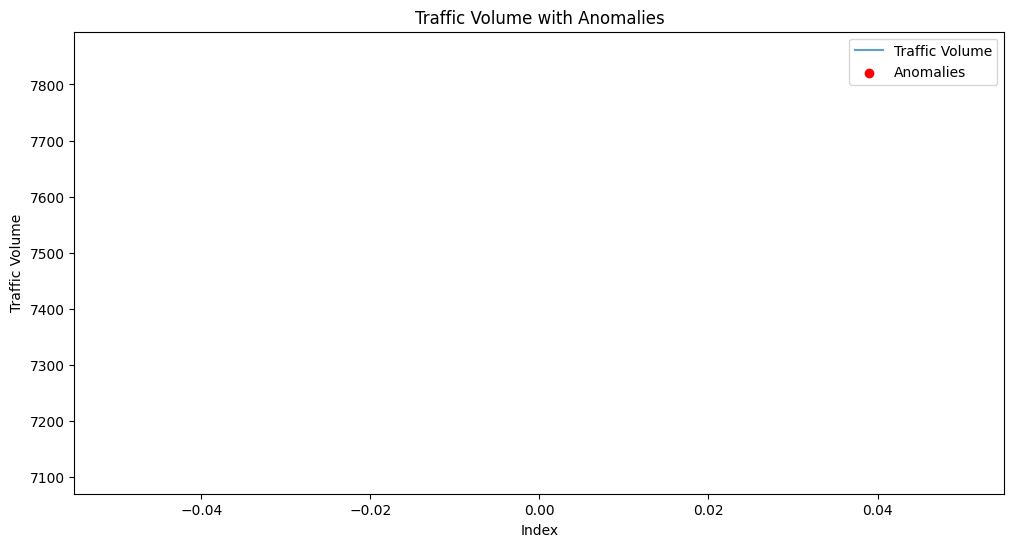

In [66]:
import matplotlib.pyplot as plt

# Visualize traffic volume with anomalies
plt.figure(figsize=(12, 6))
plt.plot(traffic_features['traffic_volume'], label='Traffic Volume', alpha=0.7)
plt.scatter(
    traffic_features.index[traffic_features['anomaly'] == 1], 
    traffic_features['traffic_volume'][traffic_features['anomaly'] == 1], 
    color='red', label='Anomalies'
)
plt.legend()
plt.title('Traffic Volume with Anomalies')
plt.xlabel('Index')
plt.ylabel('Traffic Volume')
plt.show()


In [67]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

# Define function for anomaly detection
def detect_anomalies(file_path):
    # Load uploaded CSV
    traffic = pd.read_csv(file_path)
    
    # Preprocessing and feature engineering
    traffic['Time'] = pd.to_datetime(traffic['Time'])
    traffic['protocol_encoded'] = traffic['Protocol'].astype('category').cat.codes
    scaler = MinMaxScaler()
    traffic['Length'] = scaler.fit_transform(traffic[['Length']])
    traffic['time_window'] = traffic['Time'].dt.floor('10s')
    traffic_volume = traffic.groupby('time_window')['Length'].sum().reset_index(name='traffic_volume')
    packet_count = traffic.groupby('time_window').size().reset_index(name='packet_count')
    traffic_features = pd.merge(traffic_volume, packet_count, on='time_window')
    protocol_count = traffic.groupby(['time_window', 'Protocol']).size().unstack(fill_value=0).reset_index()
    traffic_features = pd.merge(traffic_features, protocol_count, on='time_window', how='left')
    traffic_features = traffic_features.drop(columns=['time_window']).fillna(0)

    # Isolation Forest
    model = IsolationForest(contamination=0.05, random_state=42)
    traffic_features['anomaly'] = model.fit_predict(traffic_features)
    traffic_features['anomaly'] = traffic_features['anomaly'].apply(lambda x: 1 if x == -1 else 0)
    
    # Add a column for visual reference
    traffic_features['result'] = traffic_features['anomaly'].replace({1: 'Anomaly', 0: 'Normal'})
    return traffic_features

# Example Usage
file_path = "/kaggle/input/network-traffic-dataset/Midterm_53_group.csv"  # Replace with your dataset file path
results = detect_anomalies(file_path)

# Display results
print(results.head())

# Save results to CSV if needed
results.to_csv("anomaly_detection_results.csv", index=False)


   traffic_volume  packet_count  ARP  BROWSER  DHCP   DNS  HTTP  ICMP  ICMPv6  \
0      7482.39895        394136  447        8    17  1999     3  2690       9   

   NBNS  OCSP  RARP  SSLv2  STUN     TCP  TLSv1  TLSv1.2  TLSv1.3  anomaly  \
0   231   258   178     11     4  314873     20     1763    71625        0   

   result  
0  Normal  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


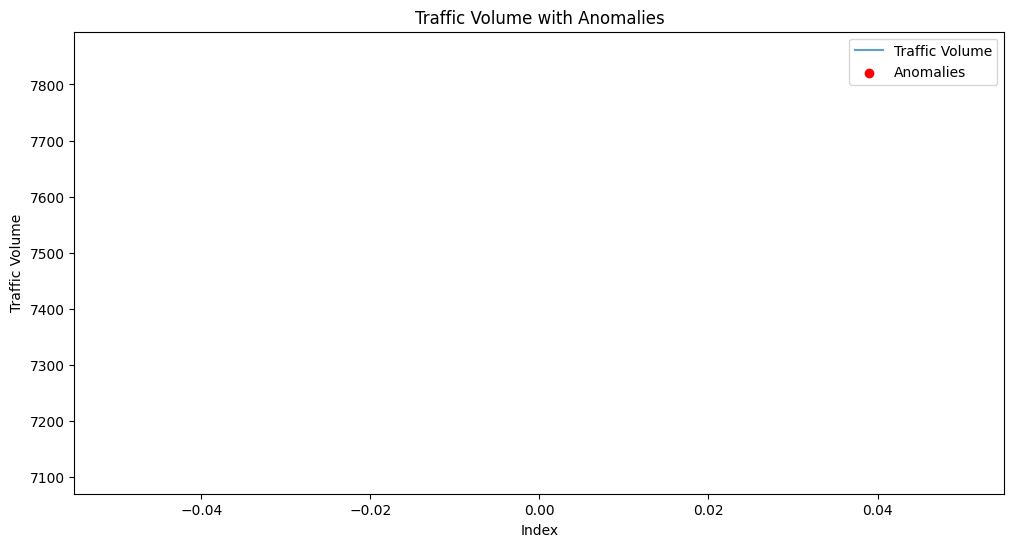

In [68]:
import matplotlib.pyplot as plt

# Visualize traffic volume with anomalies
plt.figure(figsize=(12, 6))
plt.plot(results['traffic_volume'], label='Traffic Volume', alpha=0.7)
plt.scatter(
    results.index[results['anomaly'] == 1], 
    results['traffic_volume'][results['anomaly'] == 1], 
    color='red', label='Anomalies'
)
plt.legend()
plt.title('Traffic Volume with Anomalies')
plt.xlabel('Index')
plt.ylabel('Traffic Volume')
plt.show()


# **Congestion Detection Model**
The model is designed to detect network congestion in traffic data by analyzing features like traffic volume, packet count, and time-based intervals. The goal is to predict whether a specific time window is congested or not.

Evaluation Metrics:
Confusion Matrix and Classification Report are used to assess the model's accuracy, precision, recall, and F1 score.

**43 instances of normal traffic correctly predicted as normal.
1 false positive: A congestion event incorrectly predicted as normal.
7 instances of congestion correctly predicted as congested.
0 false negatives: No congestion events missed.**

Classification Report:

**Precision for Class 0 (Normal Traffic): 1.00 (perfect precision).
Recall for Class 1 (Congestion): 1.00 (perfect recall).
Overall Accuracy: 98%, demonstrating the model's effectiveness
.Macro Average: High F1 score and recall show good performance across both classes.**


In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

def preprocess_network_data(traffic):
    # Convert Time column to timedelta in seconds
    traffic['Time'] = pd.to_timedelta(traffic['Time'], unit='s')
    
    # Create time-based features
    traffic['hour'] = traffic['Time'].dt.seconds // 3600  # Extract hours (0-23 range for analysis)
    traffic['minute'] = (traffic['Time'].dt.seconds // 60) % 60  # Extract minutes (0-59 range)
    
    # Create a time window feature with a 10-second interval
    traffic['time_window'] = (traffic['Time'].dt.total_seconds() // 10).astype(int)
    
    # Aggregate features by time window
    traffic_volume = traffic.groupby('time_window').agg({
        'Length': ['sum', 'mean', 'max'],
        'No.': 'count'
    }).reset_index()
    
    # Rename columns for clarity
    traffic_volume.columns = ['time_window', 'total_length', 'avg_length', 'max_length', 'packet_count']
    
    # Use percentile-based thresholds to label congestion
    total_length_threshold = traffic_volume['total_length'].quantile(0.85)  # Top 15% total_length
    packet_count_threshold = traffic_volume['packet_count'].quantile(0.85)  # Top 15% packet_count
    
    # Define congestion as a binary label
    traffic_volume['congestion'] = (
        (traffic_volume['total_length'] > total_length_threshold) & 
        (traffic_volume['packet_count'] > packet_count_threshold)
    ).astype(int)
    
    return traffic_volume

def prepare_features(traffic_volume):
    # Define feature columns
    features = ['total_length', 'avg_length', 'max_length', 'packet_count']
    X = traffic_volume[features]
    y = traffic_volume['congestion']
    
    # Scale features for better model performance
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

def train_congestion_model(X, y):
    # Split dataset into training and testing sets (40% for testing, stratified on target labels)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42
    )
    
    # Train a Random Forest Classifier with class weights to handle class imbalance
    model = RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Predict and evaluate model performance
    y_pred = model.predict(X_test)
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return model

def main(traffic):
    # Preprocess network traffic data
    traffic_volume = preprocess_network_data(traffic)
    
    # Prepare features and target labels
    X, y = prepare_features(traffic_volume)
    
    # Train the model and evaluate its performance
    model = train_congestion_model(X, y)
    
    return model

# Example Usage
# Ensure the dataset (traffic) has the necessary columns: Time, Length, Protocol, No., etc.
traffic = pd.read_csv("/kaggle/input/network-traffic-dataset/Midterm_53_group.csv")  # Replace with your dataset path
model = main(traffic)


Confusion Matrix:
[[43  1]
 [ 0  7]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.88      1.00      0.93         7

    accuracy                           0.98        51
   macro avg       0.94      0.99      0.96        51
weighted avg       0.98      0.98      0.98        51



In [98]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])